[1] "Connecting to Database ru"
[1] "Unable to connect to Database ru"
  device_id soil_temp soil_mc soil_ec      lat     long
1 ru-lse-20     17.35   11.74      98 54.07486 12.13715
2 ru-lse-25     17.47   23.72     257 54.04472 12.11723
3 ru-lse-27     17.04   30.27    1789 54.09742 12.15363
4 ru-lse-28     17.03   38.61    3975 53.94574 11.82129
5 ru-lse-29     16.69   12.19      49 54.07778 12.11946
6 ru-lse-30     13.91   14.85       6 54.05197 12.12959
         id    long      lat    FC  PWP VW_g_per_cm3 FC_mm PWP_mm AW_mm
1 ru-lse-02 12.1187 54.08765 32.49 14.8         1.45 121.1  64.27 76.84
2 ru-lse-20 12.1190 54.07800 30.49 14.8         1.45 141.1  64.27 76.84
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[1] "Connecting to Database bursa"
[1] "Unable to connect to Database bursa"
    device_id soil_temp soil_mc soil_ec      lat     long
1  buu-lse-01     16.62   23.72     378 40.13633 28.38297
2  buu-lse-02     15.54   20.39     260 40.1

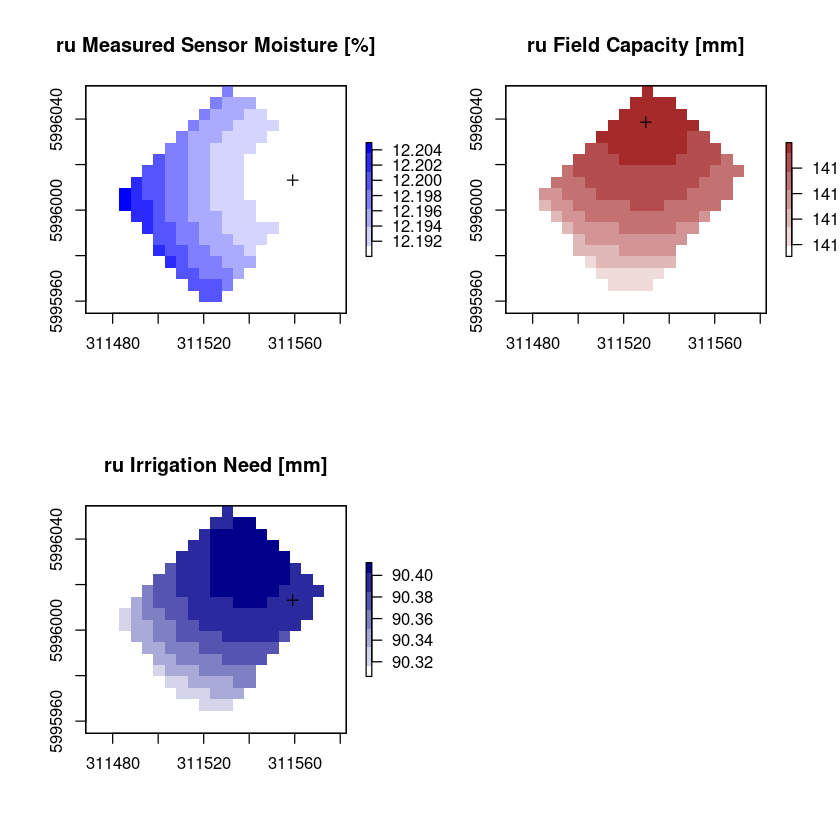

[1] "Connecting to Database ugent"
[1] "Unable to connect to Database ugent"
    device_id soil_temp soil_mc soil_ec      lat     long
1 uni-gent-23     21.41   20.37     241 50.69193 4.218750
2 uni-gent-24     21.52   25.06     724 50.93905 4.438477
            id   long      lat    FC  PWP VW_g_per_cm3 FC_mm PWP_mm AW_mm
1 ugent-lse-02 4.4389 50.93925 32.49 14.8         1.45 121.1  64.27 76.84
2 ugent-lse-20 4.4382 50.93840 30.49 14.8         1.45 141.1  64.27 76.84
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]


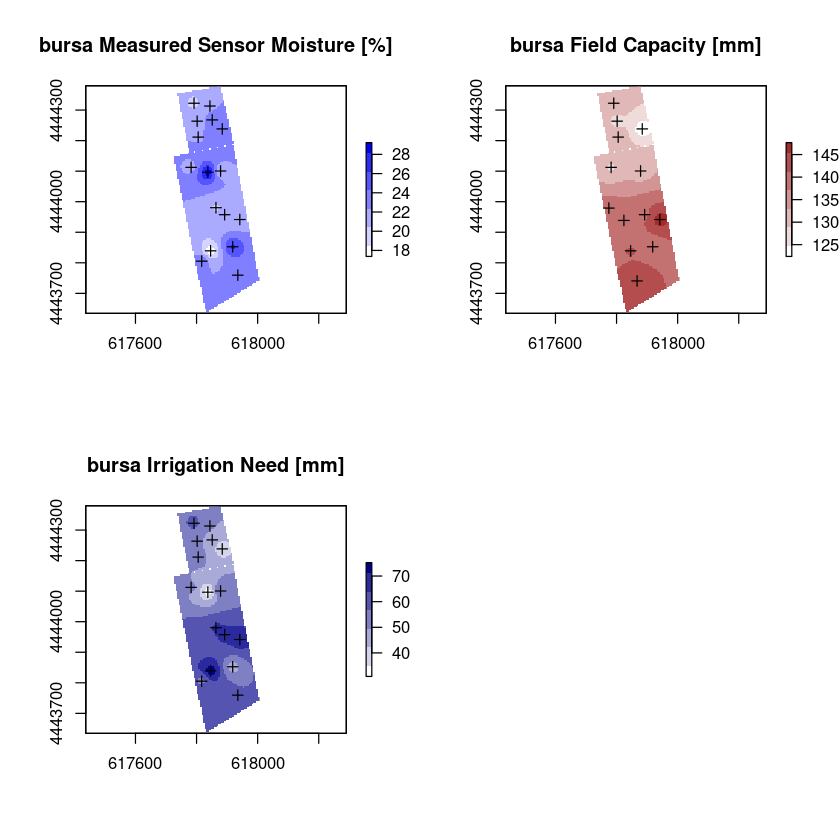

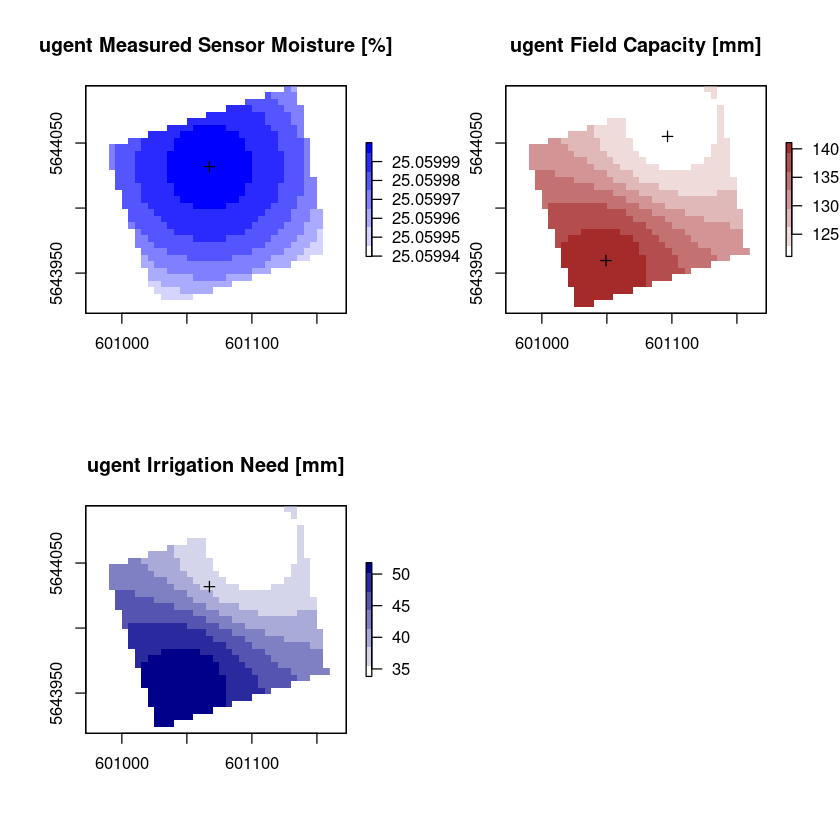

In [11]:
library(RPostgreSQL)
library(curl)
library(sf)
library(raster)
library(gstat) # Use gstat's idw routine
library(jsonlite)

university <- list("ru", "bursa", "ugent")

for (i in university) {
    ###################################################################
    ## Download the Field Mask from GeoNode
    h <- new_handle()
    handle_setopt(h, VERBOSE = 1)         #libcurl doc: https://curl.se/libcurl/c/
    handle_setopt(h, SSL_VERIFYPEER = 0)  # for insecure connections
    filename <- paste("field_boundaries_",i, sep = "")
    URL1 <- "https://geoportal.addferti.eu/geoserver/ows"
    URL2 <- "?service=WFS&version=1.0.0&request=GetFeature&typename=geonode%3A"
    URL4 <- filename
    URL5 <- "&outputFormat=json&srs=EPSG%3A32635"
    URL  <- paste(URL1,URL2,URL4,URL5,sep="")
    
    # Download the file.
    curl_download(URL, handle = h, destfile = paste(filename,".geojson", sep= ""))

    # read the data using sf (simple feature = dataframe with geometry)
    sf.Field.Mask <- st_read(paste(filename,".geojson", sep= ""),quiet = TRUE)
    
    ###################################################################
    ## Download the Soil Moisture Data from the database
    #postgreSQLTable = ['ru_soil_moisture','bursa_soil_moisture','ugent_soil_moisture']
    postgreSQLTable = paste(i,"_soil_moisture",sep="")
    dsn_database    = "lorawan"    # Postgres databasename
    dsn_hostname    = "127.0.0.1"  
    dsn_port        = "5432"                
    dsn_uid         = "postgres"            # Postgres username 
    dsn_pwd         = "postgres"            # Postgres password 
    tryCatch({
        drv <- dbDriver("PostgreSQL")
        print(paste("Connecting to Database",i))
        connec <- dbConnect(drv, 
                     dbname = dsn_database,
                     host = dsn_hostname, 
                     port = dsn_port,
                     user = dsn_uid, 
                     password = dsn_pwd)
        print("Database Connected!")
        },
        error=function(cond) {
                print(paste("Unable to connect to Database",i))
        })
    
    ## Select the most current soil moisture data
    SQL1 <- "SELECT DISTINCT ON (device_id) device_id, soil_temp, soil_mc, soil_ec, lat, long FROM"
    SQL2 <- postgreSQLTable
    SQL3 <- "ORDER BY device_id, time desc; " 
    SQL <- paste(SQL1, SQL2, SQL3)
    sensor.df <- dbGetQuery(connec, SQL)
    print(sensor.df)
    
    ###################################################################
    # Download the Field Capacity Document from Geonode
    # Find the ID of the document
    URL1 <- "https://geoportal.addferti.eu/api/v2/resources"
    URL2 <- "?search=fc_pwp_"
    URL3 <- i
    URL4 <- "&search_fields=title"
    URL  <- paste(URL1,URL2,URL3,URL4, sep="")
    
    # Download the file.
    response <- curl_fetch_memory(URL, handle = h)
    
    # Read hex to json 
    raw_json <- rawToChar(response$content)
    
    # read json to dataframe
    response_df <- fromJSON(raw_json)
    
    # access the id of the dataset
    documentID <- response_df$resources$pk
    
    # Download the Document
    URL1 <- "https://geoportal.addferti.eu/documents/"
    URL2 <- documentID
    URL3 <- "/download"
    URL <- paste(URL1,URL2,URL3,sep="")
    
    # Download the file.
    curl_download(URL, handle = h, destfile = paste("fc_pwp_",i,".txt",sep=""))
    
    # Read the data in a dataframe
    fc.df <- read.table(paste("fc_pwp_",i,".txt",sep=""),sep=',', header=TRUE)
    print(fc.df)
    
    # Make a SpatialPointsDataFrame
    data    <- fc.df[ , c("VW_g_per_cm3", "FC_mm", "PWP_mm", "AW_mm")]
    coords  <- fc.df[ , c("long", "lat")]
    crs     <- CRS("+init=epsg:4326") # => [+proj=longlat +datum=WGS84]
    fc.spdf <- SpatialPointsDataFrame(coords      = coords,
                                      data        = data, 
                                      proj4string = crs)
    
    # Reproject the crs of the fc.spdf to match the Field Mask
    fc.spdf <- spTransform(fc.spdf, crs(sf.Field.Mask))
    
    ###################################################################
    ## Interpolate the Measured Soil Moisture Content [%]
    # Make a SpatialPointsDataFrame
    data        <- sensor.df[ , c("device_id", "soil_temp", "soil_mc", "soil_ec")]
    coords      <- sensor.df[ , c("long", "lat")]
    crs         <- CRS("+init=epsg:4326") # => [+proj=longlat +datum=WGS84]
    sensor.spdf <- SpatialPointsDataFrame(coords      = coords,
                                          data        = data, 
                                          proj4string = crs)
    
    # Reproject the crs of the sensor.spdf to match the Field Mask
    sensor.spdf <- spTransform(sensor.spdf, crs(sf.Field.Mask))
    #summary(sensor_spdf)
    
    # Create an empty grid using the extends of the Field Mask with Pixel Size 1 meter
    bbox <- st_bbox(sf.Field.Mask)
    cell_size <- 5
    x <- seq(bbox$xmin, bbox$xmax, by=cell_size)
    y <- seq(bbox$ymin, bbox$ymax, by=cell_size)
    grd <- expand.grid(x=x, y=y)
    names(grd)       <- c("X", "Y")
    coordinates(grd) <- c("X", "Y")
    gridded(grd)     <- TRUE  # Create SpatialPixel object
    fullgrid(grd)    <- TRUE  # Create SpatialGrid object
    
    # Add P's projection information to the empty grid
    proj4string(grd) <- proj4string(sensor.spdf)
    
    # IDW: Interpolate using a power value of 2 (idp=2.0)
    sensor.idw <- gstat::idw(soil_mc ~ 1, sensor.spdf, newdata=grd, idp=2.0)
    
    # Convert to raster object then clip to field extend
    msmc.raster.idw <- raster(sensor.idw)
    msmc.raster.idw <- mask(msmc.raster.idw,sf.Field.Mask)
    
    ###################################################################
    ## Interpolate the Field Capacity
    # IDW: Interpolate using a power value of 2 (idp=2.0)
    fc.spdf.idw <- gstat::idw(FC_mm ~ 1, fc.spdf, newdata=grd, idp=2.0)
    
    # Convert to raster object then clip to field extend
    fc.raster.idw <- raster(fc.spdf.idw)
    fc.raster.idw <- mask(fc.raster.idw,sf.Field.Mask)
    
    ###################################################################
    ## Calculate the Irrigation need
    # msmc.raster.idw : MSMC  [%] : Measured Sensor Moisture Content [%]
    #   fc.raster.idw :   FC [mm] : Field Capacity [mm]
    # csmc.raster.idw : CSMC [mm] : Calculed Sensor Moisture Content [mm]
    #   in.raster.idw :   IN [mm] : Irrigation Need [mm]
    
    # CSMC[mm] = MSMC[%] * 300/100
    csmc.raster.idw <- msmc.raster.idw * 300/100
    
    # IN [mm] = FC [mm] * 0.9 - CSMC [mm]
    in.raster.idw <- fc.raster.idw * 0.9 - csmc.raster.idw
    
    ###################################################################
    # Plots
    
    pal1 <- colorRampPalette(c("white", "blue"))
    pal2 <- colorRampPalette(c("white", "brown"))
    pal3 <- colorRampPalette(c("white", "darkblue"))
    
    par(mfrow=c(2,2)) #Multiplot 2x2 Grid
    plot(msmc.raster.idw, col = pal1(n=7), main = paste(i,"Measured Sensor Moisture [%]"))
    plot(sensor.spdf, add=TRUE)
    plot(fc.raster.idw, col = pal2(n=7), main=paste(i,"Field Capacity [mm]"))
    plot(fc.spdf, add=TRUE)
    plot(in.raster.idw, main = paste(i,"Irrigation Need [mm]"), col = pal3(n=7))
    plot(sensor.spdf, add=TRUE)
    
    ###################################################################
    # Save the Application Map as a GeoTiff
    filename <- paste("VRI_",i,"_application_map",sep="")
    writeRaster(in.raster.idw, filename, format = "GTiff", overwrite = TRUE)
}  